<a href="https://colab.research.google.com/github/SVGS-EVA4/Phase2/blob/master/S2-MobileNets_and_ShuffleNets/Extras/Sushmitha/FinalS2Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training Custom data On Mobilenet V2 via transfer learning**


---



## **Task**
Each batch should collect 1000 images of given class and form a dataset. Should train a model to predict those images and deploy in AWS.

Classes = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']

## **Result**
1. **Maximum Train Accuracy** -  93.65%

2. **Maximum Test Accuracy** - 85.85%



---
# **Implementation Procedure**






---



## **Install torch and torchvison of version suitable for aws lambda**

In [1]:
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 27kB/s 
     |████████████████████████████████| 6.5MB 92.3MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


## **Mount Drive**

In [168]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Abumentation library for Image Agumentaion

In [3]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-01zxd8b1
Albumentation library is successfully installed!


## **Clone the library PyTNet**
(All the codes used are imported from here)

In [4]:
!git clone https://github.com/Sushmitha-Katti/PyTNet
import sys
sys.path.append("PyTNet")

Cloning into 'PyTNet'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 153 (delta 82), reused 102 (delta 40), pack-reused 0
Receiving objects: 100% (153/153), 40.03 KiB | 245.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


## **Import necessary modules**

In [6]:
import torch
import train_test_loader
import show_images
import Training.train_test
import evaluate
from Albumentationtransform import AlbumentationTransforms
from GradCam import GradCAM,visualize_cam
from LR_Range_Test import LR_test
from Dataset.Customdataset import Customdataset

## **Extract Data Set From Drive**

In [7]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/EV4P2/session2/dataset.zip","r") as zip_ref:
    zip_ref.extractall()

In [51]:
import albumentations as A
import cv2
channel_means =  (0.53105756, 0.58601165, 0.61593276)
channel_stdevs = (0.28278487, 0.25762487 ,0.29407342)
train_transform = AlbumentationTransforms([       
                                                                
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=500, min_width=500, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.Resize(250,250),
                                      A.CenterCrop(224, 224, always_apply=False, p=1.0),
                                      A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                                      A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
                                      A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=112,max_w_size = 112,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([
                                          A.Normalize(mean=channel_means, std=channel_stdevs),
                                          A.Resize(224,224),
                                          
                                        ])
train_dataset , test_dataset = CustomDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)

In [52]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=128)

## **Some Sample Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


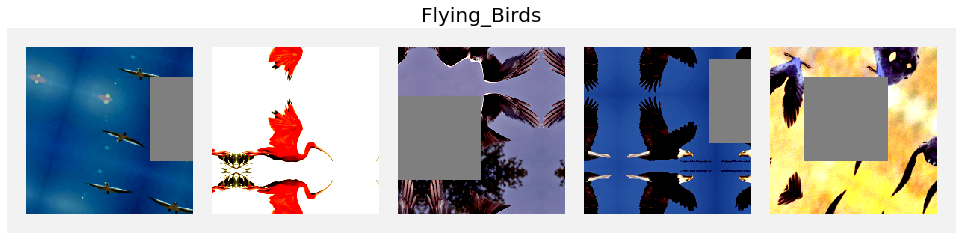

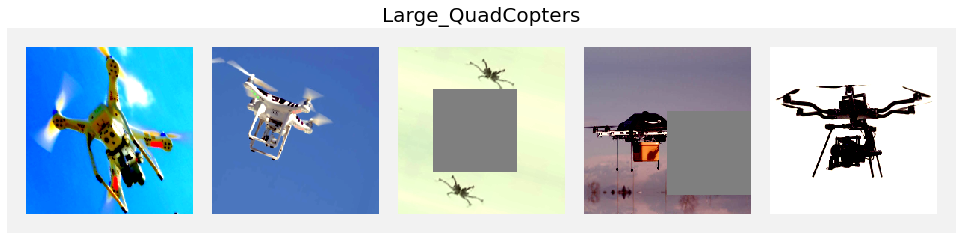

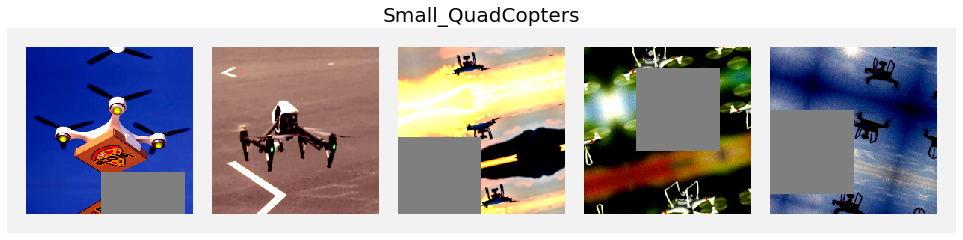

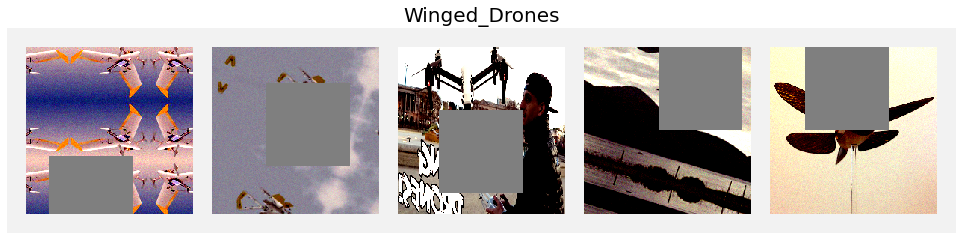

In [53]:
show_images.show_train_data(trainloader, classes)

# **Load Pretrained Mobilenet v2 Model**

In [55]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

## **Change the final no of classes to 4**

In [56]:
import torch.nn as nn
model.classifier[1] = nn.Linear(1280, 4 ,False)

## **Model Summary**

In [57]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model.to(device)
summary(model, input_size=(3, 224, 224))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1

## **Initialise Optimiser , Loss Function and Scheduler**

In [58]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR,MultiStepLR, ReduceLROnPlateau

optimizer = optim.SGD(model.parameters(), lr=0.005,momentum=0.9,weight_decay = 0.001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, factor = 0.5, patience = 2)

## **Train the Model**

In [59]:
import warnings
# There are warnings for images for conerting png, webp images to jpg. So suprresed those warnings.

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Training.train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,10,scheduler,batch_scheduler=False,best_acc = 0,path = "newtinymodel.pt")

EPOCH: 1 LR: 0.005




Test set: Average loss: 0.0035, Accuracy: 5261/6401 (82.19%)

accuracy increased, Saving model....
EPOCH: 2 LR: 0.005




Test set: Average loss: 0.0032, Accuracy: 5326/6401 (83.21%)

accuracy increased, Saving model....
EPOCH: 3 LR: 0.005




Test set: Average loss: 0.0032, Accuracy: 5326/6401 (83.21%)

EPOCH: 4 LR: 0.005




Test set: Average loss: 0.0034, Accuracy: 5336/6401 (83.36%)

accuracy increased, Saving model....
EPOCH: 5 LR: 0.005




Test set: Average loss: 0.0036, Accuracy: 5265/6401 (82.25%)

EPOCH: 6 LR: 0.0025




Test set: Average loss: 0.0032, Accuracy: 5400/6401 (84.36%)

accuracy increased, Saving model....
EPOCH: 7 LR: 0.0025




Test set: Average loss: 0.0034, Accuracy: 5401/6401 (84.38%)

accuracy increased, Saving model....
EPOCH: 8 LR: 0.0025




Test set: Average loss: 0.0032, Accuracy: 5495/6401 (85.85%)

accuracy increased, Saving model....
EPOCH: 9 LR: 0.00125




Test set: Average loss: 0.0034, Accuracy: 5385/6401 (84.13%)

EPOCH: 10 LR: 0.00125




Test set: Average loss: 0.0037, Accuracy: 5380/6401 (84.05%)



In [60]:
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Training.train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,5,scheduler,batch_scheduler=False,best_acc = 85.85,path = "newtinymodel.pt")

EPOCH: 1 LR: 0.00125




Test set: Average loss: 0.0036, Accuracy: 5385/6401 (84.13%)

EPOCH: 2 LR: 0.000625




Test set: Average loss: 0.0038, Accuracy: 5368/6401 (83.86%)

EPOCH: 3 LR: 0.000625




Test set: Average loss: 0.0036, Accuracy: 5389/6401 (84.19%)

EPOCH: 4 LR: 0.000625




Test set: Average loss: 0.0037, Accuracy: 5386/6401 (84.14%)

EPOCH: 5 LR: 0.0003125




Test set: Average loss: 0.0038, Accuracy: 5362/6401 (83.77%)



## **Final Accuracy Of the Model**

In [69]:
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 85.85 %


In [65]:
classes = ('Flying_Birds' , 'Large_QuadCopters'  , 'Small_QuadCopters'  , 'Winged_Drones' )

## **Classwise Accuaracy**

In [165]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of Flying_Birds : 97%
Accuracy of Large_QuadCopters : 76%
Accuracy of Small_QuadCopters : 62%
Accuracy of Winged_Drones : 89%


# **Some Misclassified Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

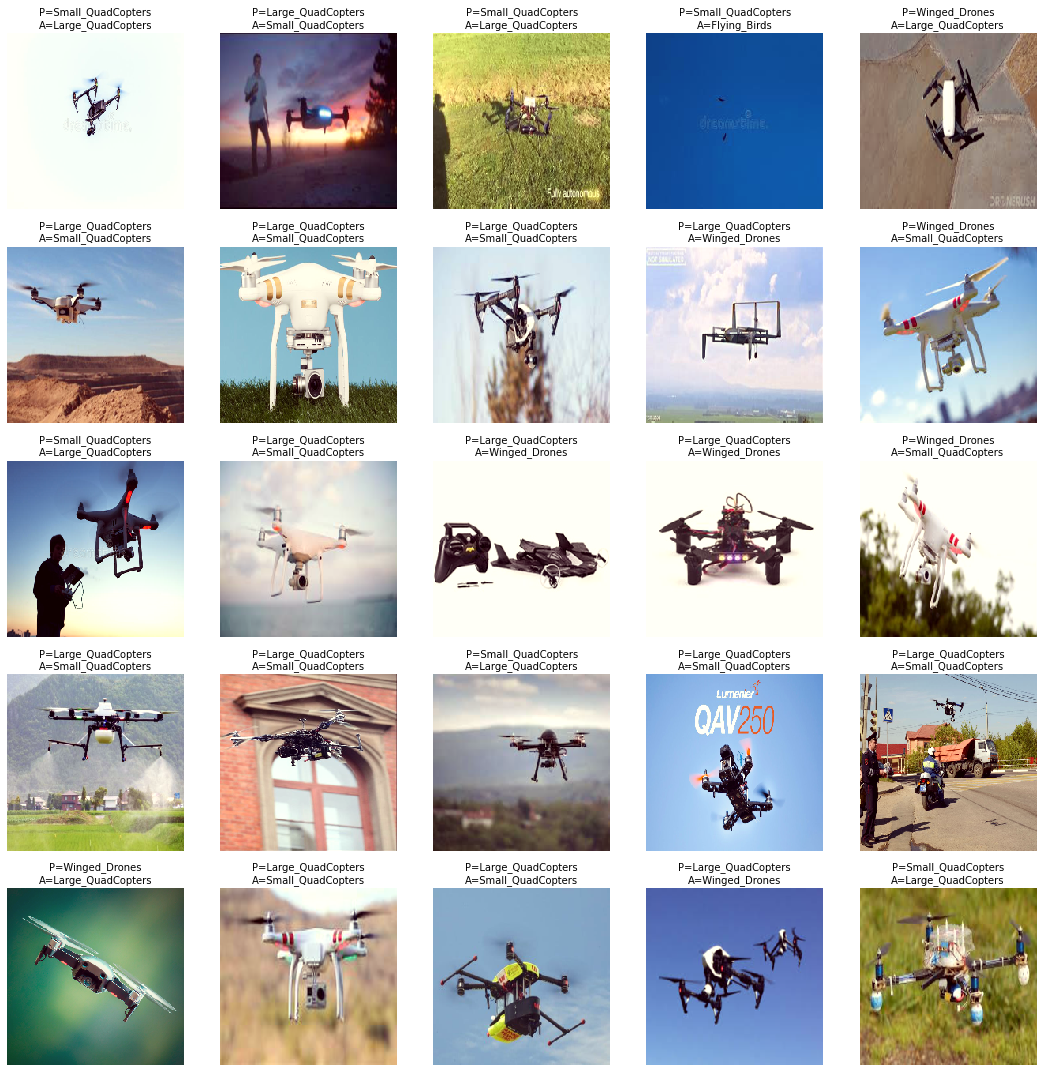

In [166]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    evaluate.misclassified_images = evaluate.show_misclassified_images(model, device, testloader, classes,number = 25)
    evaluate.plot_misclassified_images(misclassified_images, classes,Figsize = (15,15),number = 25)

In [125]:
test_acc  = Training.train_test.test_acc
train_acc = Training.train_test.train_acc
test_loss = Training.train_test.test_losses
train_loss = Training.train_test.train_losses


## **Accuracy Plot**

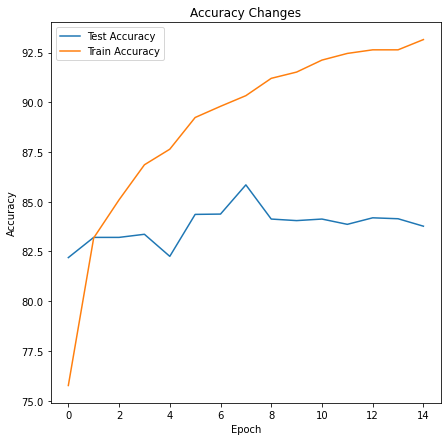

In [133]:
import warnings


curves = [{"y":test_acc[10:] , "label": "Test Accuracy","xlabel": "Epoch", "ylabel":"Accuarcy" },{"y":train_acc [10:], "label": "Train Accuracy","xlabel": "Epoch", "ylabel":"Accuracy" }]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    evaluate.plot_curve(curves,"Accuracy Changes",Figsize = (7,7))

## **Loss Plot**

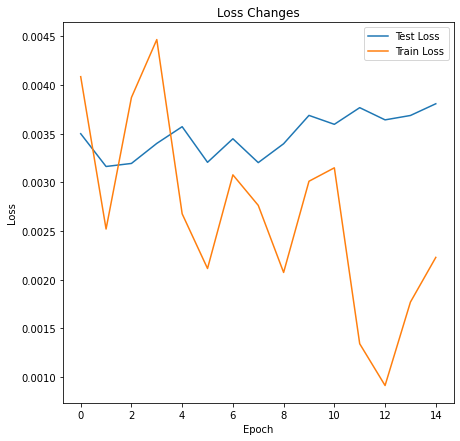

In [139]:
import warnings


curves = [{"y":test_loss[10:] , "label": "Test Loss","xlabel": "Epoch", "ylabel":"loss" },{"y":train_loss [10:], "label": "Train Loss","xlabel": "Epoch", "ylabel":"Loss" }]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_curve(curves,"Loss Changes",Figsize = (7,7))

## **Change in Learning Rate Plot**

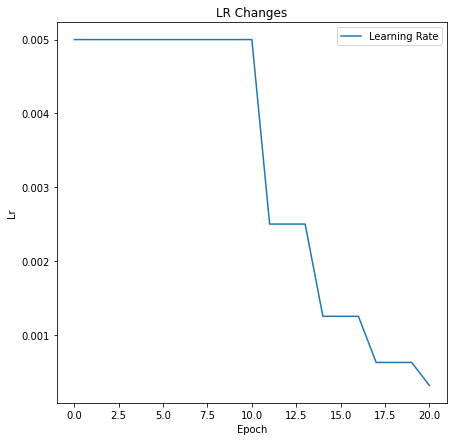

In [167]:
import warnings


curves = [{"y":Training.train_test.LR[10:] , "label": "Learning Rate","xlabel": "Epoch", "ylabel":"Lr" }]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_curve(curves,"LR Changes",Figsize = (7,7))

## **Load and Save the model to cpu, trace it and save it again**
(this saved model will be used for deployment in AWS) 


In [63]:
checkpoint = torch.load('/content/newtinymodel.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to('cpu')
model.eval()
traced_model = torch.jit.trace(model,torch.randn(1,3,244,244)) 
traced_model.save('finalmodel.pt')